In [ ]:
# !apt-get install git-lfs
# !git lfs install  
# !git clone https://github.com/calico/spatial_lda.git
# !pip install lifelines
# !pip install palettable


# package location: /wynton/home/engelhardt/chwu/miniconda3/envs/NSF38/lib/python3.8/site-packages/spatial_lda

In [1]:
import os
import sys

os.chdir("/wynton/home/engelhardt/chwu/Projects/HubID/SpatialLDA")
PATH_TO_MODELS = f'./models/'
#PATH_TO_DF_PKL = f'./data//spleen_df.pkl'
PATH_TO_FEATURES_PKL = f'./data/cells_features_default_binary_subregion2.pkl'

# paths = [
#   PATH_TO_MODELS,
#   PATH_TO_SPLEEN_DF_PKL
# ]

# paths_exist = {path: os.path.exists(path) for path in paths}
# display(paths_exist)
# assert all(paths_exist.values())


In [2]:
%load_ext autoreload
%autoreload 2

import functools
import logging
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import pickle
import scipy
import seaborn as sns
from sklearn.model_selection import train_test_split
import time
import tqdm
# Spatial LDA imports
from spatial_lda.featurization import neighborhood_to_cluster, neighborhood_to_marker_binary
from spatial_lda.featurization import make_nearest_neighbor_graph
from spatial_lda.featurization import make_merged_difference_matrices
from spatial_lda.featurization import featurize_samples
from spatial_lda.visualization import plot_samples_in_a_row
from spatial_lda.visualization import plot_bcell_topic_multicolor
import spatial_lda.model

N_PARALLEL_PROCESSES = 8#@param
TRAIN_SIZE_FRACTION = 0.99 #@param
N_TOPICS_LIST = [3, 5, 8, 10] #@param

logger = logging.getLogger()
logger.setLevel(logging.INFO)

/wynton/home/engelhardt/chwu/miniconda3/envs/NSF38/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [39]:
import inspect
lines = inspect.getsource(neighborhood_to_marker_binary)
print(lines)

def neighborhood_to_marker_binary(df, indices, markers):
    return (df.loc[:, markers].iloc[indices] > 0.5).sum()



In [5]:
# visualization parameters
blue = sns.color_palette()[0]
green = sns.color_palette()[1]
red = sns.color_palette()[2]
sns.set_context("paper",font_scale=1)
sns.set_style('white')
sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 1.0})

In [6]:
# mtx=scipy.sparse.load_npz("../neighbor_smooth/Data/G4423_15_neighbor_sums.npz")
# with open("../neighbor_smooth//Data/G4423_15_neighbor_sums_colnames.csv", "r+") as file1:
#     # Reading form a file
#     colnames=file1.read()
    
# colnames=colnames.strip("\n").split(",")


mtx=pd.read_csv("/gladstone/engelhardt/pelka-collaboration/Broad_MERFISH_Datasets/G4423_20220427/cellpose_cell_by_gene.csv")

In [7]:
mtx=mtx.iloc[:,1:]
mtx

COL3A1  HLA-E  VIM  JUN  STMN1  ASCL2  TIMP1  HLA-DRB1  DNAJB1  PSMB8  \
0          0.0    0.0  0.0  0.0    0.0    0.0    0.0       0.0     0.0    0.0   
1          0.0    0.0  0.0  0.0    0.0    0.0    0.0       0.0     0.0    0.0   
2          0.0    0.0  0.0  0.0    0.0    0.0    0.0       0.0     0.0    0.0   
3          0.0    0.0  0.0  0.0    0.0    0.0    0.0       0.0     0.0    0.0   
4          0.0    0.0  0.0  0.0    0.0    0.0    0.0       0.0     0.0    0.0   
...        ...    ...  ...  ...    ...    ...    ...       ...     ...    ...   
546284     0.0    1.0  0.0  0.0    0.0    0.0    0.0       0.0     0.0    0.0   
546285     1.0    3.0  0.0  2.0    0.0    0.0    0.0       0.0     1.0    0.0   
546286     0.0    3.0  0.0  0.0    0.0    0.0    0.0       0.0     0.0    0.0   
546287     0.0    1.0  1.0  0.0    0.0    0.0    0.0       0.0     0.0    0.0   
546288     0.0    0.0  0.0  0.0    0.0    0.0    0.0       0.0     0.0    0.0   

        ...  Blank-27  Blank-68  UBE2C  Blank-62  SPP1  Blank-17  Blank-40  \
0       ...       0.0       0.0    0.0       0.0   0.0       0.0       0.0   
1       ...       0.0       0.0    0.0       0.0   0.0       0.0       0.0   
2       ...       0.0       0.0    0.0       0.0   0.0       0.0       0.0   
3       ...       0.0       0.0    0.0       0.0   0.0       0.0       0.0   
4       ...       0.0       0.0    0.0       0.0   0.0       0.0       0.0   
...     ...       ...       ...    ...       ...   ...       ...       ...   
546284  ...       0.0       0.0    0.0       0.0   0.0       0.0       0.0   
546285  ...       0.0       0.0    0.0       0.0   0.0       0.0       0.0   
546286  ...       0.0       0.0    0.0       0.0   0.0       0.0       0.0   
546287  ...       0.0       0.0    0.0       0.0   0.0       0.0       0.0   
546288  ...       0.0       0.0    0.0       0.0   0.0       0.0       0.0   

        COL10A1  Blank-9  Blank-59  
0           0.0      0.0       0.0  
1           0.0      0.0       0.0  
2           0.0      0.0       0.0  
3           0.0      0.0       0.0  
4           0.0      0.0       0.0  
...         ...      ...       ...  
546284      0.0      0.0       0.0  
546285      0.0      0.0       0.0  
546286      0.0      0.0       0.0  
546287      0.0      0.0       0.0  
546288      0.0      0.0       0.0  

[546289 rows x 550 columns]

In [8]:
markers= mtx.columns
markers=markers.tolist()
len(markers)

550

In [ ]:
# mtx2=scipy.sparse.csr_matrix(np.array(mtx))
# scipy.sparse.save_npz('./Data/G4423_15_neighbor_sums.npz', mtx2)

In [ ]:
# mtx=pd.DataFrame(mtx.todense())
# mtx.columns=colnames
# mtx=mtx.iloc[:,1:]
# mtx

In [9]:
# import spatial info
#meta=pd.read_csv('/wynton/group/gladstone/users/cywu/Broad_MERFISH_Datasets/G4423_20220427/cellpose_cell_metadata.csv')
meta=pd.read_csv('/gladstone/engelhardt/pelka-collaboration/Broad_MERFISH_Datasets/G4423_20220427/cellpose_cell_metadata.csv')
coordinates0=np.array(meta[['center_x', 'center_y']])
coordinates=coordinates0
coordinates


array([[11034.14202732,  2966.53593962],
       [11038.9741895 ,  2965.83061915],
       [11058.40741954,  2981.00772623],
       ...,
       [11842.5858035 ,  8817.65049918],
       [11746.48760914,  8818.06972971],
       [11733.95617749,  8819.07830778]])

In [10]:
# flip y
coordinates[:,1]=max(coordinates0[:,1])-coordinates0[:,1]


In [11]:
idx=range((mtx.shape[0]))
print(mtx.loc[idx].shape)
print(mtx.shape)

(546289, 550)
(546289, 550)


In [ ]:
#print(list(mtx.columns[0:550]))

# Generate inputs for running Spatial LDA

In [12]:
mtx['isb']=True
mtx['sample']='G4423'
mtx['sample.X']=coordinates[:,0]
mtx['sample.Y']=coordinates[:,1]



In [13]:
# subsample and generate dic
import random
random.seed(100)
#idx=random.sample(range((mtx.shape[0])), 5000)#int(mtx.shape[0]*0.1))
idx=np.array([*range(mtx.shape[0])])
idx=idx[((coordinates[:,0]>4500) & (coordinates[:,0]<7000)) & ((coordinates[:,1]<max(coordinates[:,1])) & (coordinates[:,1]>(max(coordinates[:,1])-2500)))]

df_dict = {'G4423': mtx.loc[idx]}
#df_dict['G4423_2']=mtx.loc[idx[1000:2000]]
df_dict

{'G4423':         COL3A1  HLA-E  VIM   JUN  STMN1  ASCL2  TIMP1  HLA-DRB1  DNAJB1  \
 6404       0.0    0.0  0.0   1.0    0.0    0.0    0.0       0.0     0.0   
 6405       0.0    0.0  0.0   0.0    0.0    0.0    0.0       0.0     0.0   
 6431       0.0   10.0  0.0   0.0    1.0    0.0    0.0       0.0     1.0   
 6437       0.0    6.0  2.0   1.0    0.0    0.0    0.0       0.0     0.0   
 6444       0.0    0.0  0.0   0.0    0.0    0.0    0.0       0.0     1.0   
 ...        ...    ...  ...   ...    ...    ...    ...       ...     ...   
 507795     2.0    1.0  0.0   0.0    0.0    0.0    0.0       0.0     1.0   
 507796     1.0    4.0  0.0   0.0    0.0    0.0    0.0       0.0     1.0   
 507797     2.0    2.0  5.0  10.0    0.0    1.0    0.0       0.0     4.0   
 507798    13.0    3.0  3.0   0.0    0.0    0.0    0.0       0.0     0.0   
 507800     1.0    2.0  0.0   0.0    0.0    0.0    0.0       0.0     2.0   
 
         PSMB8  ...  SPP1  Blank-17  Blank-40  COL10A1  Blank-9  Blank-59  \


In [ ]:
# Featurize the data
#%%time
for df in df_dict.values():
    df['x'] = df['sample.X']
    df['y'] = df['sample.Y']
#wt_samples = [ x for x in codex_df_dict.keys() if x.startswith("BALBc")]
#spleen_dfs = dict(zip(wt_samples, [ codex_df_dict[x] for x in wt_samples]))

neighborhood_feature_fn = functools.partial(neighborhood_to_marker_binary, 
                                              markers=markers)  

cells_features = featurize_samples(df_dict, neighborhood_feature_fn, 100,'isb',
                             'sample.X', 'sample.Y', include_anchors=True, #all cells are ahcnors
                             n_processes=N_PARALLEL_PROCESSES)


#featurize_spleens(spleen_dfs, neighborhood_to_cluster, radius=100,n_processes=N_PARALLEL_PROCESSES)
with open(PATH_TO_FEATURES_PKL, 'wb') as f:
    pickle.dump(cells_features, f)


  0%|                                                     | 0/1 [00:00<?, ?it/s]

In [40]:
cells_features

COL3A1  HLA-E  VIM  JUN  STMN1  ASCL2  TIMP1  HLA-DRB1  \
(G4423, 6404)        19     60   23   21      4      0      8         2   
(G4423, 6405)        18     60   22   19      5      0      8         2   
(G4423, 6431)        16     39   13   14      2      0      6         1   
(G4423, 6437)        19     47   17   18      4      0      7         1   
(G4423, 6444)        31     75   29   29      8      0     10         1   
...                 ...    ...  ...  ...    ...    ...    ...       ...   
(G4423, 507795)     106    132   70   41     28     51     20         9   
(G4423, 507796)     123    165   97   68     28     44     31        10   
(G4423, 507797)     107    133   73   41     27     52     20        10   
(G4423, 507798)     117    155   84   46     26     53     20         9   
(G4423, 507800)     129    168  106   72     30     46     33        10   

                 DNAJB1  PSMB8  ...  Blank-27  Blank-68  UBE2C  Blank-62  \
(G4423, 6404)        50     19  ...         0         1      4         0   
(G4423, 6405)        48     20  ...         0         1      4         0   
(G4423, 6431)        33      8  ...         0         0      0         0   
(G4423, 6437)        40     11  ...         0         0      0         0   
(G4423, 6444)        67     21  ...         0         1      4         0   
...                 ...    ...  ...       ...       ...    ...       ...   
(G4423, 507795)     107     36  ...         1         1     26         1   
(G4423, 507796)     140     42  ...         1         1     30         1   
(G4423, 507797)     111     34  ...         1         1     26         1   
(G4423, 507798)     132     35  ...         2         1     25         1   
(G4423, 507800)     145     45  ...         1         2     33         1   

                 SPP1  Blank-17  Blank-40  COL10A1  Blank-9  Blank-59  
(G4423, 6404)      13         2         1        0        0         0  
(G4423, 6405)      13         2         1        0        0         0  
(G4423, 6431)       5         0         1        0        0         0  
(G4423, 6437)       6         1         1        0        0         0  
(G4423, 6444)      11         2         1        0        0         0  
...               ...       ...       ...      ...      ...       ...  
(G4423, 507795)    38         2         3        3        0         0  
(G4423, 507796)    47         1         0        0        2         1  
(G4423, 507797)    40         2         3        3        0         0  
(G4423, 507798)    47         2         3        3        1         0  
(G4423, 507800)    48         1         0        0        2         1  

[41128 rows x 550 columns]

In [ ]:
# for df in df_dict.values():
#     df['x'] = df['sample.X']
#     df['y'] = df['sample.Y']
# #wt_samples = [ x for x in codex_df_dict.keys() if x.startswith("BALBc")]
# #spleen_dfs = dict(zip(wt_samples, [ codex_df_dict[x] for x in wt_samples]))

# #neighborhood_feature_fn = functools.partial(neighborhood_to_marker_binary, 
# #                                              markers=markers)  

# cells_features = pickle.load(PATH_TO_FEATURES_PKL)

# #featurize_samples(df_dict, neighborhood_feature_fn, 100,'isb',
# #                             'sample.X', 'sample.Y', include_anchors=True, #all cells are ahcnors
# #                             n_processes=N_PARALLEL_PROCESSES)


# #featurize_spleens(spleen_dfs, neighborhood_to_cluster, radius=100,n_processes=N_PARALLEL_PROCESSES)
# # with open(PATH_TO_FEATURES_PKL, 'wb') as f:
# #     pickle.dump(cells_features, f)


In [20]:
difference_matrices = make_merged_difference_matrices(cells_features, df_dict,
                                                             'sample.X', 'sample.Y')
all_sample_idxs = cells_features.index.map(lambda x: x[0])
_sets = train_test_split(cells_features, 
                         test_size=1. - TRAIN_SIZE_FRACTION,
                         stratify=all_sample_idxs)
train_cells_features, test_cells__features = _sets
train_difference_matrices = make_merged_difference_matrices(
    train_cells_features, df_dict,
    'sample.X', 'sample.Y')
train_idxs = train_cells_features.index.map(lambda x: x[0])

In [ ]:
from spatial_lda.visualization import plot_adjacency_graph

def make_plot_fn(difference_matrices):  
    def plot_fn(ax, tumor_idx, features_df, patient_dfs):
        plot_adjacency_graph(ax, tumor_idx, features_df, patient_dfs, difference_matrices)
    return plot_fn
_plot_fn = make_plot_fn(difference_matrices)

plot_samples_in_a_row(cells_features, _plot_fn, df_dict)

In [ ]:
from spatial_lda.visualization import plot_samples_in_a_row
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
from matplotlib.backends.backend_pdf import PdfPages
from spatial_lda.visualization import plot_samples_in_a_row
with PdfPages('./plots/G4423_default_binary_subregion2_adjacency.pdf') as pdf_pages:
    # df1 = dftest.select_dtypes([np.int, np.float, np.object])
    # for i, col in enumerate(N_TOPICS_LIST):
    #     figu = plt.figure(i)
    #     plot = sns.countplot(x=col, data=df1)
    #     pdf_pages.savefig(figu)
    plt.figure()
    plot_samples_in_a_row(cells_features, _plot_fn, df_dict)
    pdf_pages.savefig()
    plt.close()

In [ ]:
cells_features

# Spatial LDA results

In [41]:
#N_TOPICS_LIST = [3, 5, 8, 10, 20] #@param
N_TOPICS_LIST = [30, 50] #@param
N_TOPICS_LIST

[30, 50]

In [44]:
from spatial_lda.model import order_topics_consistently
spatial_lda_models = {}  
difference_penalty = 0.25#10000000000#0.25  
for n_topics in N_TOPICS_LIST:
  path_to_train_model = '_'.join((f'{PATH_TO_MODELS}/training_default_binary_subregion2',
                                  f'penalty={difference_penalty}',
                                  f'topics={n_topics}',
                                  f'trainfrac={TRAIN_SIZE_FRACTION}')) + '.pkl'
  if not os.path.exists(path_to_train_model):
    print(f'Running n_topics={n_topics}, d={difference_penalty}\n')
    spatial_lda_model = spatial_lda.model.train(sample_features=train_cells_features, 
                                                difference_matrices=train_difference_matrices,
                                                difference_penalty=difference_penalty,
                                                n_topics=n_topics,
                                                n_parallel_processes=N_PARALLEL_PROCESSES,                                                                         
                                                verbosity=1,
                                                admm_rho=0.1,
                                                primal_dual_mu=1e+5)
    spatial_lda_models[n_topics] = spatial_lda_model
    with open(path_to_train_model, 'wb') as f:
      pickle.dump(spatial_lda_model, f)    
  else:
    with open(path_to_train_model, 'rb') as f:
      spatial_lda_models[n_topics] = pickle.load(f)
      
order_topics_consistently(spatial_lda_models.values())     

INFO:root:>>> Starting iteration 0


Running n_topics=30, d=0.25



LDA training: 100%|███████████████████████████████| 5/5 [01:49<00:00, 21.99s/it]
INFO:root:>>> Iteration 0, M-step took 171.77889561653137 seconds.

Update xi:   0%|                                          | 0/1 [03:55<?, ?it/s]


Exception: Stopping in admm.newton_regularized_dirichlet.

In [ ]:
# lda_3 = spatial_lda_models[3]
# topic_weights_3 = lda_3.topic_weights
# lda_5 = spatial_lda_models[5]
# topic_weights_5 = lda_5.topic_weights
# lda_8 = spatial_lda_models[8]
# topic_weights_8 = lda_8.topic_weights
# lda_10 = spatial_lda_models[10]
# topic_weights_10 = lda_10.topic_weights
# lda_20 = spatial_lda_models[20]
# topic_weights_20 = lda_20.topic_weights
lda_30 = spatial_lda_models[30]
topic_weights_30 = lda_30.topic_weights
lda_50 = spatial_lda_models[50]
topic_weights_50 = lda_50.topic_weights
samples = ['G4423']

In [38]:
from spatial_lda.visualization import plot_samples_in_a_row
from spatial_lda.visualization import plot_bcell_topic_multicolor
from spatial_lda.visualization import plot_topic_multicolor
from matplotlib.backends.backend_pdf import PdfPages
with PdfPages('./plots/G4423_default_binary_subregion2_topic_weights_extend_new_30_50.pdf') as pdf_pages:
    # df1 = dftest.select_dtypes([np.int, np.float, np.object])
    # for i, col in enumerate(N_TOPICS_LIST):
    #     figu = plt.figure(i)
    #     plot = sns.countplot(x=col, data=df1)
    #     pdf_pages.savefig(figu)
    
#     plt.figure()
#     plot_samples_in_a_row(topic_weights_3, plot_topic_multicolor, df_dict, tumor_set=samples)
#     pdf_pages.savefig(bbox_inches="tight", pad_inches=0.2)
#     plt.close()
    
#     plt.figure()
#     plot_samples_in_a_row(topic_weights_5, plot_topic_multicolor, df_dict, tumor_set=samples)
#     pdf_pages.savefig(bbox_inches="tight", pad_inches=0.2)
#     plt.close()
    
#     plt.figure()
#     plot_samples_in_a_row(topic_weights_8, plot_topic_multicolor, df_dict, tumor_set=samples)
#     pdf_pages.savefig(bbox_inches="tight", pad_inches=0.2)
#     plt.close()
    
#     plt.figure()
#     plot_samples_in_a_row(topic_weights_10, plot_topic_multicolor, df_dict, tumor_set=samples)
#     pdf_pages.savefig(bbox_inches="tight", pad_inches=0.2)
#     plt.close()
    
    plt.figure()
    plot_topic_multicolor_fn = functools.partial(plot_topic_multicolor, seed=23)  
    plot_samples_in_a_row(topic_weights_30, plot_topic_multicolor_fn, df_dict, tumor_set=samples)    
    pdf_pages.savefig(bbox_inches="tight", pad_inches=0.2)
    plt.close()
    
    plt.figure()
    plot_topic_multicolor_fn = functools.partial(plot_topic_multicolor, seed=23)  
    plot_samples_in_a_row(topic_weights_50, plot_topic_multicolor_fn, df_dict, tumor_set=samples)    
    pdf_pages.savefig(bbox_inches="tight", pad_inches=0.2)
    plt.close()
    
#     plt.figure()
#     plot_samples_in_a_row(topic_weights_30,plot_topic_multicolor4, df_dict, tumor_set=samples)
#     pdf_pages.savefig()
#     plt.close()
    
    

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
# ## plot one topic at a time for 20 30 50

# from spatial_lda.visualization import plot_samples_in_a_row
# from spatial_lda.visualization import plot_bcell_topic_multicolor
# from spatial_lda.visualization import plot_topic_multicolor
# from matplotlib.backends.backend_pdf import PdfPages
# with PdfPages('./plots/G4423_default_binary_subregion2_topic_weights_extend_new_30_50.pdf') as pdf_pages:




In [136]:
# save topic info to csv using for loop
all_vars=dir()
sel_vars=[]
for ii in all_vars:
    if "topic_weights_" in ii:
        sel_vars.append(ii)
print(sel_vars)

['topic_weights_10', 'topic_weights_20', 'topic_weights_3', 'topic_weights_5', 'topic_weights_8']


In [ ]:
for ii in sel_vars[0:(len(sel_vars)-1)]:
    lda=globals()[ii]
    topic_word = (lda.components_)/(lda.components_).sum(axis=1)[:, np.newaxis]
    topic_word_df=pd.DataFrame(topic_word)
    topic_word_df.columns=markers
    topic_word_df.to_csv("./tables/G4420_subregion2_default_binary_topic_word_"+ii+"_30_50.csv")
    print(ii)

In [90]:
## generate object for plotting
topic_weights=topic_weights_3

# index for the subset of cells
idx=[]
for ii in topic_weights.index:
    idx.append(ii[1])
    
mtx.iloc[(idx),:]
#coordinates[idx,:]


COL3A1  HLA-E   VIM  JUN  STMN1  ASCL2  TIMP1  HLA-DRB1  DNAJB1  \
246624     3.0    3.0   0.0  1.0    1.0    1.0    0.0       0.0     0.0   
11283      1.0    1.0   1.0  1.0    0.0    0.0    0.0       0.0     1.0   
458619     0.0    0.0   0.0  0.0    0.0    0.0    0.0       0.0     0.0   
232541     2.0    3.0   0.0  1.0    0.0    1.0    0.0       0.0     4.0   
258281     1.0    0.0   1.0  0.0    0.0    0.0    0.0       0.0     0.0   
...        ...    ...   ...  ...    ...    ...    ...       ...     ...   
505560     0.0    4.0   0.0  0.0    0.0    0.0    2.0       0.0     1.0   
257819     2.0    0.0   1.0  0.0    0.0    0.0    0.0       0.0     0.0   
136268     2.0    6.0  14.0  1.0    0.0    0.0    0.0       0.0     0.0   
10693      0.0    1.0   0.0  0.0    0.0    0.0    0.0       0.0     3.0   
332165     8.0    2.0   1.0  1.0    0.0    1.0    0.0       0.0     1.0   

        PSMB8  ...  SPP1  Blank-17  Blank-40  COL10A1  Blank-9  Blank-59  \
246624    0.0  ...   1.0       0.0       0.0      0.0      0.0       0.0   
11283     0.0  ...   0.0       0.0       0.0      0.0      0.0       0.0   
458619    0.0  ...   0.0       0.0       0.0      0.0      0.0       0.0   
232541    0.0  ...   0.0       0.0       0.0      0.0      0.0       0.0   
258281    0.0  ...   0.0       0.0       0.0      0.0      0.0       0.0   
...       ...  ...   ...       ...       ...      ...      ...       ...   
505560    0.0  ...   1.0       0.0       0.0      0.0      0.0       0.0   
257819    0.0  ...   0.0       0.0       0.0      0.0      0.0       0.0   
136268    0.0  ...   0.0       0.0       0.0      0.0      0.0       0.0   
10693     0.0  ...   0.0       0.0       0.0      0.0      0.0       0.0   
332165    0.0  ...   0.0       0.0       0.0      0.0      0.0       0.0   

         isb  sample     sample.X      sample.Y  
246624  True   G4423  6594.984718   9793.604093  
11283   True   G4423  5123.373152  11559.388280  
458619  True   G4423  6654.058783  10102.540977  
232541  True   G4423  4745.730226  10728.259202  
258281  True   G4423  5212.233022  10663.861274  
...      ...     ...          ...           ...  
505560  True   G4423  5808.681200  10607.656226  
257819  True   G4423  5373.201618  10828.413378  
136268  True   G4423  5355.124831  11419.116445  
10693   True   G4423  4580.718004  11747.060059  
332165  True   G4423  5990.705322   9624.327882  

[40716 rows x 554 columns]

In [94]:
tmp=mtx.iloc[idx,0:550]

In [113]:
# generate object
import scanpy as sc
adata_sub = sc.AnnData(tmp)#, 
    #tmp.index.to_frame(), 
    #tmp.columns.to_frame())
adata_sub.obsm['spatial']=coordinates[idx,:]



/scratch/chwu/ipykernel_12680/1479717046.py:3: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_sub = sc.AnnData(tmp)#,
/wynton/home/engelhardt/chwu/miniconda3/envs/NSF38/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [118]:
topic_weights

K=topic_weights.shape[1]

Topic-0   Topic-1   Topic-2
(G4423, 246624)  0.247227  0.341248  0.411525
(G4423, 11283)   0.340815  0.640712  0.018473
(G4423, 458619)  0.210619  0.096869  0.692513
(G4423, 232541)  0.760536  0.235404  0.004060
(G4423, 258281)  0.667423  0.084918  0.247659
...                   ...       ...       ...
(G4423, 505560)  0.692604  0.173892  0.133503
(G4423, 257819)  0.589533  0.089790  0.320677
(G4423, 136268)  0.073534  0.665735  0.260731
(G4423, 10693)   0.062550  0.906546  0.030904
(G4423, 332165)  0.014075  0.010611  0.975314

[40716 rows x 3 columns]

In [125]:
for ii in range(K):
    adata_sub.obs['LDA'+str(ii)]=np.array(topic_weights.iloc[:,ii])

In [128]:
# compute the most possible clusters for each cell/spot
clusters=[]
for ii in range(topic_weights.shape[0]):
    clusters.append(np.array(topic_weights)[ii,:].argmax())
adata_sub.obs['LDA_cluster']=clusters
adata_sub.obs=adata_sub.obs.astype({'LDA_cluster':'category'})

0
1
2


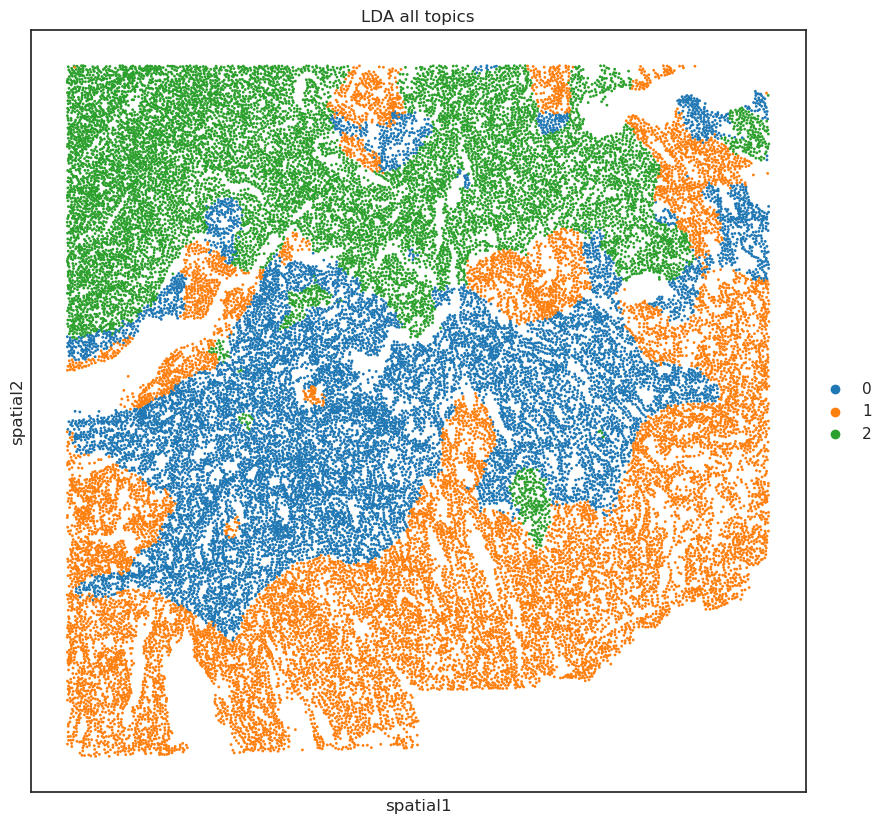

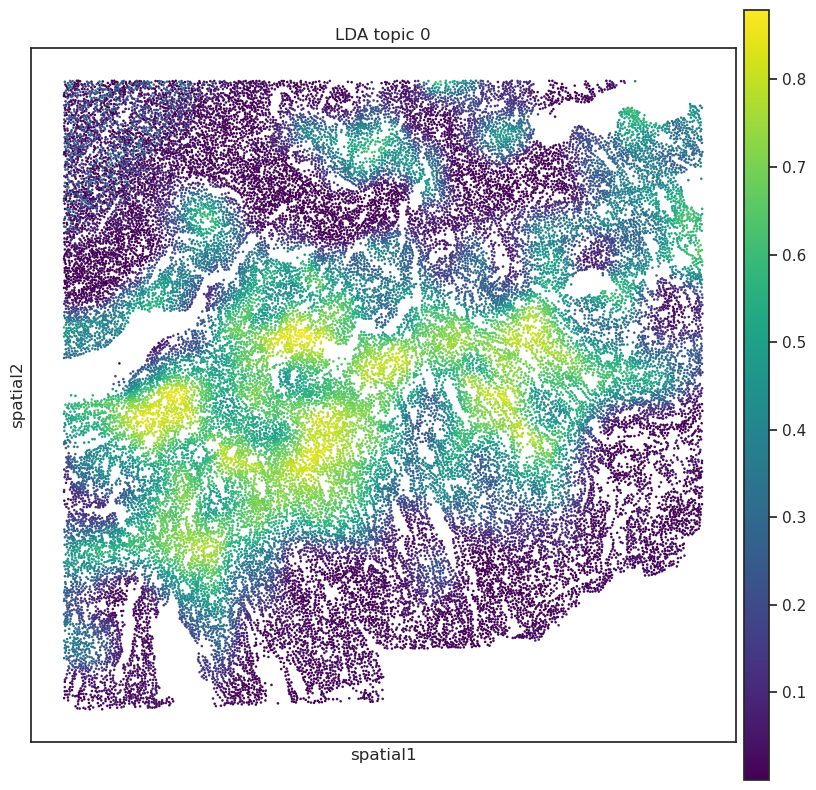

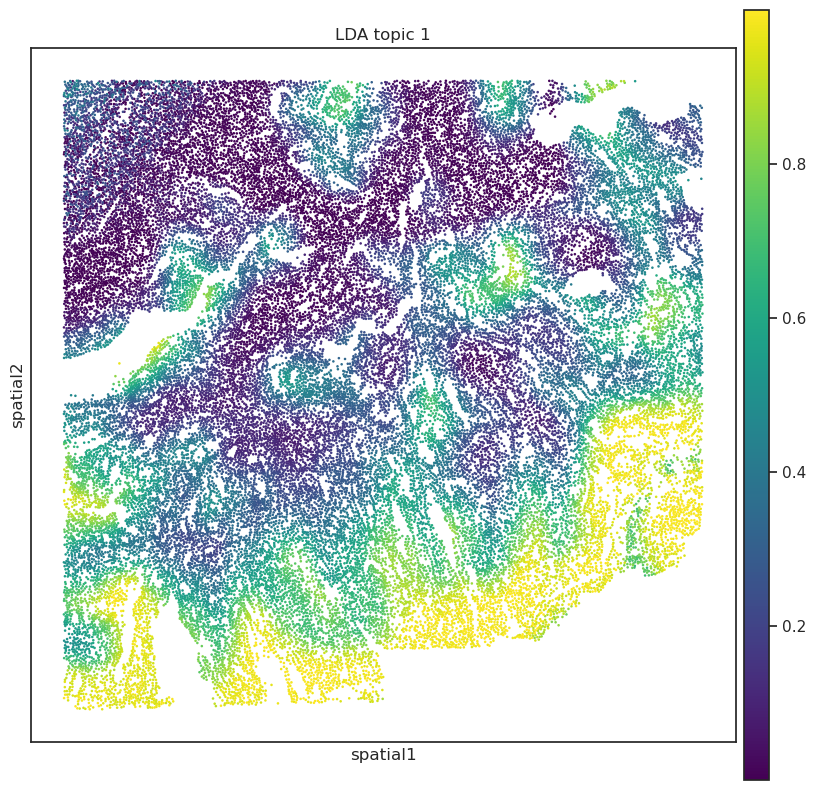

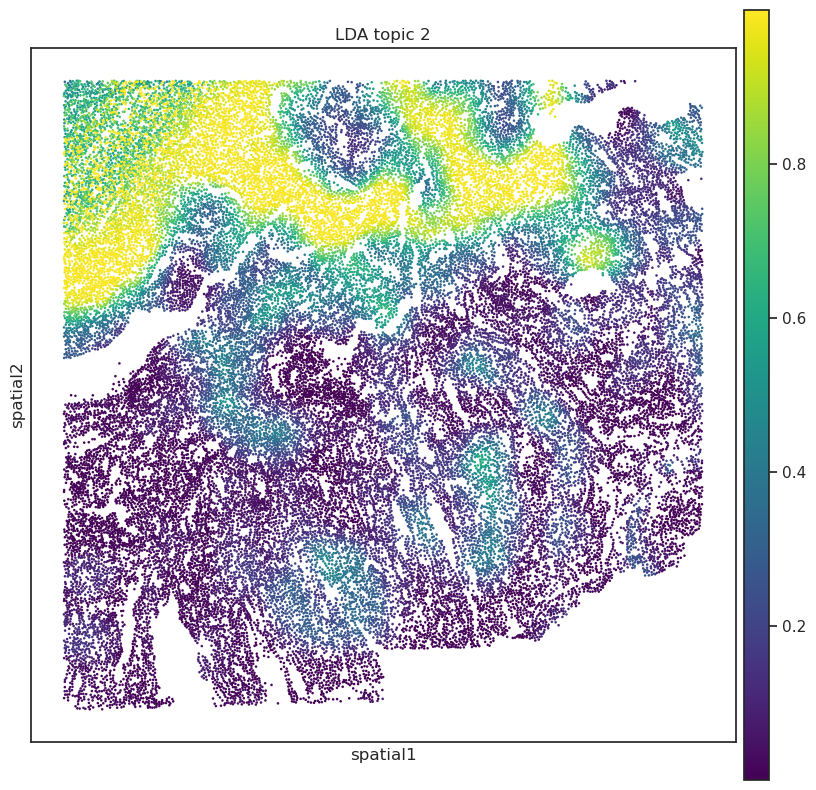

In [133]:
## plot continuous activity scores
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf

pdf = matplotlib.backends.backend_pdf.PdfPages("./plots/G4423_default_binary_subregion2_topic_weights_extend_new_LDA3_continous_activity_score.pdf")
fig, (ax1) = plt.subplots(1, 1, figsize=(10,10), gridspec_kw={'wspace':0.9})
#ax1.set_xlim(minn,maxx)
#ax1.set_ylim(minn,maxx)
#ax1.set_title("HDP all topics")
sc.pl.spatial(adata_sub, spot_size=10, color=['LDA_cluster'],title="LDA all topics" , show=False, ax=ax1)
pdf.savefig( fig )

for ii in range(K):
    fig, (ax1) = plt.subplots(1, 1, figsize=(10,10), gridspec_kw={'wspace':0.9})
    #ax1.set_xlim(minn,maxx)
    #ax1.set_ylim(minn,maxx)
    #ax1.set_title("HDP_topic"+str(ii))
    sc.pl.spatial(adata_sub, spot_size=10, color=['LDA'+str(ii)], show=False, title="LDA topic "+str(ii),ax=ax1, color_map="viridis")
    pdf.savefig( fig )
    print(ii)

pdf.close()   




In [33]:
for ii in sel_vars[0:(len(sel_vars)-1)]:
    lda=globals()[ii]
    topic_word = (lda.components_)/(lda.components_).sum(axis=1)[:, np.newaxis]
    topic_word_df=pd.DataFrame(topic_word)
    topic_word_df.columns=markers
    topic_word_df.to_csv("./tables/G4420_subregion2_default_binary_topic_word_"+ii+"_30_50.csv")
    print(ii)

lda_10
lda_20
lda_3
lda_5
lda_8


In [ ]:
# no prior
from spatial_lda.visualization import plot_samples_in_a_row
from spatial_lda.visualization import plot_bcell_topic_multicolor3
from spatial_lda.visualization import plot_topic_multicolor3

plot_samples_in_a_row(topic_weights_3, plot_bcell_topic_multicolor3, df_dict, tumor_set=samples)
plot_samples_in_a_row(topic_weights_5, plot_bcell_topic_multicolor3, df_dict, tumor_set=samples)
plot_samples_in_a_row(topic_weights_8, plot_bcell_topic_multicolor3, df_dict, tumor_set=samples)
plot_samples_in_a_row(topic_weights_10, plot_bcell_topic_multicolor3, df_dict, tumor_set=samples)
plot_samples_in_a_row(topic_weights_20, plot_topic_multicolor3, df_dict, tumor_set=samples)

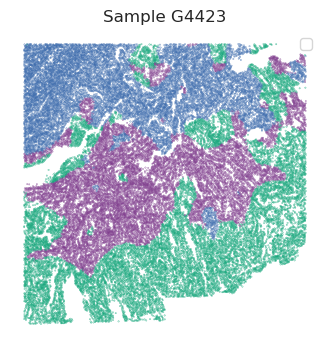

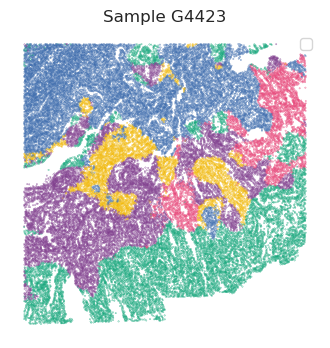

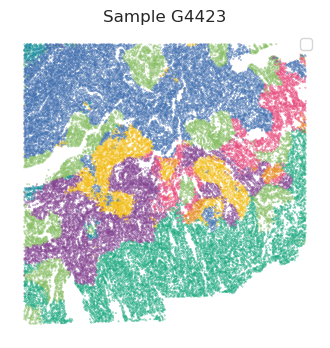

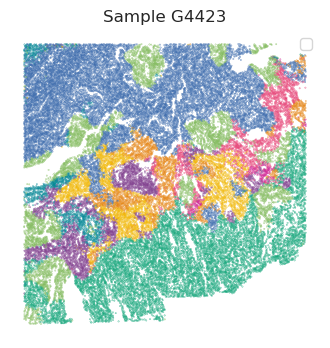

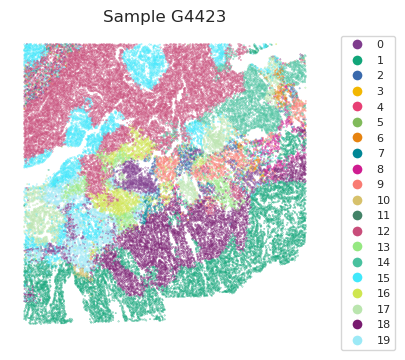

In [68]:
## both prior and smoothing
from spatial_lda.visualization import plot_samples_in_a_row
from spatial_lda.visualization import plot_bcell_topic_multicolor
from spatial_lda.visualization import plot_topic_multicolor

plot_samples_in_a_row(topic_weights_3, plot_bcell_topic_multicolor, df_dict, tumor_set=samples)
plot_samples_in_a_row(topic_weights_5, plot_bcell_topic_multicolor, df_dict, tumor_set=samples)
plot_samples_in_a_row(topic_weights_8, plot_bcell_topic_multicolor, df_dict, tumor_set=samples)
plot_samples_in_a_row(topic_weights_10, plot_bcell_topic_multicolor, df_dict, tumor_set=samples)
plot_samples_in_a_row(topic_weights_20, plot_topic_multicolor, df_dict, tumor_set=samples)

In [69]:
topic_weights_3

Topic-0   Topic-1   Topic-2
(G4423, 246624)  0.247227  0.341248  0.411525
(G4423, 11283)   0.340815  0.640712  0.018473
(G4423, 458619)  0.210619  0.096869  0.692513
(G4423, 232541)  0.760536  0.235404  0.004060
(G4423, 258281)  0.667423  0.084918  0.247659
...                   ...       ...       ...
(G4423, 505560)  0.692604  0.173892  0.133503
(G4423, 257819)  0.589533  0.089790  0.320677
(G4423, 136268)  0.073534  0.665735  0.260731
(G4423, 10693)   0.062550  0.906546  0.030904
(G4423, 332165)  0.014075  0.010611  0.975314

[40716 rows x 3 columns]